In [2]:
from collections import defaultdict
import math
import numpy as np
from numpy import ma
import datetime, time
from datetime import datetime
import netCDF4
from netCDF4 import Dataset, num2date
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

import pickle
import halem
import datetime, time
import numpy as np
timeQ = time

"disable functions below if cartopy is unavailable"
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import halem
import halem.Mesh_maker as Mesh_maker
import halem.Flow_class as Flow_class
import flow_class
import os
from pandas import DataFrame

from IPython.display import clear_output

# Create list with names of the netCDF files in the directory

In [2]:
number_downloads = 140
directory = 'D:/Tidal_ananlysis_data/'
source = 'dcsmv6_zunov4_zuno_kf_hirlam'

t0 = '08/05/2018 06:00:00'
t1 = '08/05/2018 00:00:00'
t2 = '08/05/2018 05:50:00'

t0 = datetime.datetime.strptime(t0, "%d/%m/%Y %H:%M:%S").timestamp()
t1 = datetime.datetime.strptime(t1, "%d/%m/%Y %H:%M:%S").timestamp()
t2 = datetime.datetime.strptime(t2, "%d/%m/%Y %H:%M:%S").timestamp()

now = '201905140000'
urls = []
names = []

for i in range(number_downloads):
    ana = datetime.datetime.fromtimestamp(t0+i*60*60*6).strftime('%Y%m%d%H%M')
    fro = datetime.datetime.fromtimestamp(t1+i*60*60*6).strftime('%Y%m%d%H%M')
    to = datetime.datetime.fromtimestamp(t2+i*60*60*6).strftime('%Y%m%d%H%M')
    
    url = 'http://matroos.rws.nl:80//matroos/scripts/matroos.pl?source={}&anal={}&z=0&xmin=-4.300000&xmax=9.600000&ymin=49.200001&ymax=57.200001&coords=WGS84&xmin_abs=-4.3000001907349&xmax_abs=9.6000003814697&ymin_abs=49.200000762939&ymax_abs=57.200000762939&color=VELU,VELV,SEP&interpolate=&now={}&to={}2350&from={}&outputformat=nc&stridex=1&stridey=1&stridetime=1&xn=&yn=&celly=&cellx=&fieldoutput=VELU,VELV,SEP&format=nc'.format(source, ana, now, to, fro)
    urls.append(url)
    names.append(ana)
    
del names[95]
del urls[95]

# create function that extrcacts d,u,v from netCDF file

In [3]:
def flow_func(name):
    nc = Dataset(directory +name+'.nc')

    x_domain = (300,-260)
    y_domain = (-450,-370)

    x = nc.variables['x'][:,:]
    y = nc.variables['y'][:,:]
    x = x[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
    y = y[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]

    x_temp = ma.array(x.reshape(x.size))
    y_temp = ma.array(y.reshape(x.size))

    nodes = np.zeros((y_temp[y_temp.mask == False].size,2))
    nodes[:,0] = y_temp[y_temp.mask == False]
    nodes[:,1] = x_temp[y_temp.mask == False]

    t = nc.variables['time'][:]
    t = t *60 - 60*60*2

    d = nc.variables['SEP'][:,:,:]
    d = d[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]

    u = nc.variables['VELU'][:,:,:]
    u = u[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]

    v = nc.variables['VELV'][:,:,:]
    v = v[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]


    u_n = []
    v_n = []
    d_n = []

    for node in nodes:
        xloc = np.argwhere(x == node[1])[0,1]
        yloc = np.argwhere(y == node[0])[0,0]
        u_n.append(u[:,yloc,xloc])
        v_n.append(v[:,yloc,xloc])
        d_n.append(d[:,yloc,xloc])

    d_n = np.array(d_n)
    d_n[d_n < -600] = 0
    v_n = np.array(v_n)
    v_n[v_n < -600] = 0
    u_n = np.array(u_n)
    u_n[u_n < -600] = 0

    d = np.transpose(d_n)
    v = np.transpose(v_n)
    u = np.transpose(u_n)
    
    return nodes, d, v, u, t

# Load the flow for each file in the directory 

In [4]:
start_time = time.time()

nodes, d, u, v, t = flow_func(names[0])

for i in range(1,len(names)):
    _, d_temp, u_temp, v_temp, t_temp = flow_func(names[i])
    d = np.concatenate((d, d_temp))
    u = np.concatenate((u, u_temp))
    v = np.concatenate((v, v_temp))
    t = np.concatenate((t, t_temp))
    
    clear_output(wait = True)
    print((i+1)/len(names) * 100, '%')
    
stop_time = time.time()
computation_time = stop_time - start_time
print("the computational time is:", round(computation_time,2), "sec")

100.0 %
the computational time is: 1164.27 sec


In [5]:
np.savetxt('D:/Use_case_Schouwen/tidal_an/nodes.csv', nodes)
np.savetxt('D:/Use_case_Schouwen/tidal_an/t.csv', t)
np.savetxt('D:/Use_case_Schouwen/tidal_an/d.csv', d)
np.savetxt('D:/Use_case_Schouwen/tidal_an/u.csv', u)
np.savetxt('D:/Use_case_Schouwen/tidal_an/v.csv', v)

In [36]:
name = names[0]
nc = Dataset(directory +name+'.nc')

x_domain = (300,-260)
y_domain = (-450,-370)

x = nc.variables['x'][:,:]
y = nc.variables['y'][:,:]
x = x[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]
y = y[x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]


d = nc.variables['SEP'][:,:,:]
d = d[:,x_domain[0]:x_domain[1], y_domain[0]:y_domain[1]]

(51.55, 52)

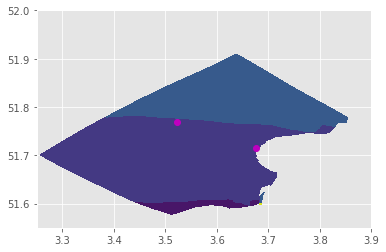

In [37]:
plt.contourf(x,y,d[0])
start = [3.676014309976414,51.71540093282213]
stop = [3.522637481591586,51.76880095558772]

plt.plot(start[0], start[1],'mo')
plt.plot(stop[0], stop[1], 'mo')

plt.xlim(0,5)
plt.ylim(50,55)

plt.xlim(3.25,3.9)
plt.ylim(51.55,52)